In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import clear_output

In [3]:
from transformers import Seq2SeqTrainer
from transformers import Seq2SeqTrainingArguments
from transformers import T5Config
from transformers import T5ForConditionalGeneration
from transformers import T5Tokenizer
from transformers import set_seed

In [4]:
from datetime import datetime
import argparse
import os
import sys

sys.path.append("./hf_transformers/")

In [5]:
import torch

from data_reader import GetDataAsPython
from prepare_data import create_data
from prepare_data import create_dataset
from prepare_data import extract_warning_types
from utils import boolean_string
from utils import get_current_time
import csv
import numpy as np

In [6]:
storage_directory = './storage/'

In [7]:
import random

In [8]:
exec_number = random.randint(0, 1000)
exec_number

10

In [9]:
repo = '/data/all/data/zloirock/core-js'
repo

'/data/all/data/zloirock/core-js'

In [10]:
sample_percent = 0.0
sample_percent

0.0

In [11]:
name='added'
name

'added'

In [12]:
# Read and prepare data
data = GetDataAsPython(f"{storage_directory}/data_and_models/data/data_autofix_tracking_repo_specific_final.json")
data_eslint = GetDataAsPython(f"{storage_directory}/data_and_models/data/data_autofix_tracking_eslint_final.json")
data += data_eslint

In [13]:
len(data)

104804

In [14]:
all_warning_types = extract_warning_types(data)

In [15]:
(repo_train_inputs, repo_train_labels, repo_val_inputs, repo_val_labels, repo_test_inputs, repo_test_labels, repo_train_info, repo_val_info, repo_test_info, ) =\
    create_data(data, all_warning_types, include_warning=True, design='repo-based-included', select_repo=repo)

splitting by : repo-based-included
train size: 136
val size: 13
test size: 52


In [16]:
(general_train_inputs, general_train_labels, general_val_inputs, general_val_labels, general_test_inputs, general_test_labels, general_train_info, general_val_info, general_test_info, ) =\
    create_data(data, all_warning_types, include_warning=True, design='repo-based')

splitting by : repo-based
train size: 95109
val size: 5033
test size: 1262


In [17]:
from transformers import AutoTokenizer, AutoModel

code_bert_model = AutoModel.from_pretrained("microsoft/codebert-base")
code_bert_model.to('cuda')

code_bert_tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")

In [18]:
def code_to_vec(code): # probably need a normalization
    code_tokens=code_bert_tokenizer.tokenize(code)
    tokens=[code_bert_tokenizer.cls_token]+code_tokens+[code_bert_tokenizer.sep_token]
    tokens_ids=code_bert_tokenizer.convert_tokens_to_ids(tokens)
    context_embeddings=code_bert_model(torch.tensor(tokens_ids).to('cuda')[None,:])[0]
    return context_embeddings[0][0].cpu().detach().numpy()
def vec_distance(code1, code2):
    n_code1 = code1/np.linalg.norm(code1)
    n_code2 = code1/np.linalg.norm(code2)
    return np.linalg.norm(n_code1 - n_code2)

In [19]:
repo_vecs = np.array([code_to_vec(item) for item in repo_train_inputs])

In [20]:
repo_vecs.shape

(136, 768)

In [21]:
from sklearn.neighbors import NearestNeighbors

In [22]:
# repo_center = np.average(repo_vecs, axis=0)

In [23]:
# %%time
# general_vecs = np.array([code_to_vec(item[:512]) for item in general_train_inputs[:]])

In [24]:
# general_vecs.shape

In [25]:
# np.save('general_arr_all.npy', general_vecs)

In [26]:
general_vecs = np.load('general_arr_all.npy')
general_vecs.shape

(95109, 768)

In [27]:
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(repo_vecs)

In [28]:
distances, indices = nbrs.kneighbors(general_vecs)

In [29]:
# diffs = [vec_distance(general_vec, repo_center) for general_vec in general_vecs]

(array([1.4000e+01, 3.4500e+02, 6.7190e+03, 6.1043e+04, 2.4028e+04,
        2.6840e+03, 2.4500e+02, 2.2000e+01, 4.0000e+00, 5.0000e+00]),
 array([0.        , 0.50694202, 1.01388403, 1.52082605, 2.02776807,
        2.53471008, 3.0416521 , 3.54859412, 4.05553613, 4.56247815,
        5.06942017]),
 <BarContainer object of 10 artists>)

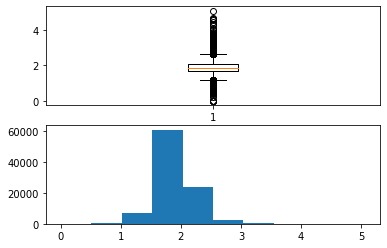

In [30]:
import matplotlib.pyplot as plt
plt.subplot(2, 1, 1)
plt.boxplot(distances)
plt.subplot(2, 1, 2)
plt.hist(distances)

In [31]:
repo_nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(repo_vecs)
repo_distances, index = repo_nbrs.kneighbors(repo_vecs)
repo_distances.shape

(136, 2)

(array([17., 18., 16., 10., 23., 24., 17.,  2.,  5.,  4.]),
 array([0.32845291, 0.53171225, 0.73497158, 0.93823092, 1.14149026,
        1.34474959, 1.54800893, 1.75126826, 1.9545276 , 2.15778693,
        2.36104627]),
 <BarContainer object of 10 artists>)

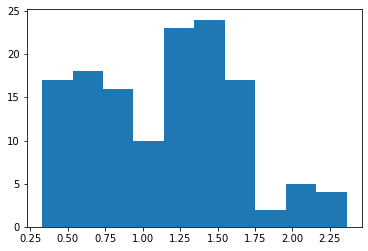

In [32]:
plt.hist(repo_distances[:,1])

In [33]:
# top_n = 597#int(len(diffs) / 10)
# top_n

In [41]:
selected = (distances < 0.93)
selected.sum()

172

In [42]:
# selected_ind = np.argpartition(diffs, top_n)[:top_n]

In [43]:
# np.array(diffs)[selected_ind].mean(), np.array(diffs).mean()

In [44]:
added_inputs = list()
added_labels = list()
added_info = list()
for ind in range(len(general_train_inputs)):
    if selected[ind]:
        added_inputs.append(general_train_inputs[ind])
        added_labels.append(general_train_labels[ind])
        added_info.append(general_train_info[ind])

In [45]:
# Create dataset required by pytorch
samples = int(sample_percent * len(repo_train_inputs))
print(f'{len(repo_train_inputs)} {samples} {sample_percent}')

136 0 0.0


In [46]:
len(repo_train_inputs), len(added_inputs)

(136, 172)

In [47]:
added_inputs += repo_train_inputs[:samples]
added_labels += repo_train_labels[:samples]
added_info += repo_train_info[:samples]

In [48]:
validation_point = int((len(added_inputs) * 4) / 5)

In [49]:
len(added_inputs)

172

In [50]:
load_model = f'./{storage_directory}/checkpoint-37375'
tokenizer = T5Tokenizer.from_pretrained(load_model)

In [51]:
train_dataset = create_dataset(added_inputs[:validation_point], added_labels[:validation_point], tokenizer, pad_truncate=True, max_length=128)
val_dataset = create_dataset(added_inputs[validation_point:], added_labels[validation_point:], tokenizer, pad_truncate=True)
test_dataset = create_dataset(repo_val_inputs, repo_val_labels, tokenizer, pad_truncate=True)

/home/armin/TFix/env/lib/python3.8/site-packages/transformers/models/t5/tokenization_t5.py:181: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


In [52]:
now = datetime.now()
test_result_directory = f'{storage_directory}/fine-tune-result'
full_name = f'{name}_{exec_number}_{repo.rsplit("/", 1)[1][-20:]}_{sample_percent}_{selected.sum()}'
model_directory = f'{storage_directory}/tmp/{full_name}'
model_directory

'./storage//tmp/added_10_core-js_0.0_172'

In [53]:
lr = 4e-3
ws = 300
wd = 0.4
lr, wd, ws

(0.004, 0.4, 300)

In [54]:
tokenizer = T5Tokenizer.from_pretrained(load_model)
model = T5ForConditionalGeneration.from_pretrained(load_model)
model.resize_token_embeddings(len(tokenizer))
# model.eval()

Embedding(32104, 512)

In [55]:
from transformers import EarlyStoppingCallback

training_args = Seq2SeqTrainingArguments(
    output_dir=model_directory,
    num_train_epochs=15,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=ws,
    weight_decay=wd,
    logging_dir=model_directory,
    logging_steps=100,
    do_eval=True,
    evaluation_strategy="epoch",
    learning_rate=lr,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    save_total_limit=1,
    eval_accumulation_steps=1,  # set this lower, if testing or validation crashes
    disable_tqdm=False,
    predict_with_generate=True,  # never set this to false.
    seed=42,  # default value
)

In [56]:
# from sklearn.metrics import accuracy_score
# import numpy as np
# def compute_metrics(p):
#     target_max_length = 256
#     predictions, labels = p.predictions, p.label_ids
    
#     predictions = np.pad(predictions, ((0, 0), (0, target_max_length - predictions.shape[1])), mode="constant")
#     predictions = np.delete(predictions, 0, axis=1)
#     predictions = np.insert(predictions, target_max_length - 1, 0, axis=1)

#     labels = np.array(labels)
#     labels = np.pad(labels, ((0, 0), (0, target_max_length - labels.shape[1])), mode="constant")
#     labels = np.delete(labels, 0, axis=1)
#     labels = np.insert(labels, target_max_length - 1, 0, axis=1)

#     correct_counter = np.sum(np.all(np.equal(labels, predictions), axis=1))
#     return {'acc': int(correct_counter)}

In [57]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    optimizers=[torch.optim.Adam(params=model.parameters(), lr=lr), None],
    tokenizer=tokenizer,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=5)]
#     compute_metrics=compute_metrics
)

In [58]:
trainer.train()

Epoch,Training Loss,Validation Loss,Runtime,Samples Per Second
1,No log,0.052705,0.109200,320.530000
2,No log,0.051527,0.112900,309.940000
3,No log,0.062978,0.110800,315.742000
4,No log,0.062700,0.110100,317.767000
5,No log,0.064449,0.111500,313.974000
6,No log,0.068093,0.110500,316.825000
7,No log,0.069507,0.110800,315.749000


TrainOutput(global_step=63, training_loss=0.056056809803796195, metrics={'train_runtime': 16.9118, 'train_samples_per_second': 7.983, 'total_flos': 44554804396032, 'epoch': 7.0})

In [59]:
trainer.evaluate()['eval_loss']

0.05152716487646103

In [60]:
trainer.predict(test_dataset).metrics

{'eval_loss': 0.2893669903278351,
 'eval_runtime': 0.2373,
 'eval_samples_per_second': 54.783}

In [61]:
best_model_dir = f'{model_directory}/best'
trainer.save_model(best_model_dir)
best_model_dir

'./storage//tmp/added_10_core-js_0.0_172/best'

In [62]:
# del train_dataset
# del test_dataset
# del val_dataset
# del trainer

In [63]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [64]:
!python hf_transformers/tfix_testing.py --load-model $best_model_dir -bs 16 --model-name t5-small -d repo-based-included -r $repo

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
start time:  18:30:41
['no-invalid-this', 'no-throw-literal', 'no-new-wrappers', 'guard-for-in', 'no-new-object', 'comma-style', 'prefer-spread', 'no-caller', 'no-extra-bind', 'no-array-constructor', 'prefer-rest-params', 'generator-star-spacing', 'no-this-before-super', 'no-extend-native', 'no-undef', 'no-useless-escape', 'no-dupe-keys', 'no-console', 'no-constant-condition', 'no-duplicate-case', 'no-empty', 'no-extra-semi', 'no-redeclare', 'no-cond-assign', 'no-extra-boolean-cast', 'no-fallthrough', 'no-unreachable', 'valid-typeof', 'no-unsafe-finally', 'no-unused-vars', 'no-debugger', 'no-unsafe-negation', 'no-case-declarations', 'no-self-assign', 'no-process-exit'

In [65]:
!echo $best_model_dir $repo 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
./storage//tmp/added_10_core-js_0.0_172/best /data/all/data/zloirock/core-js
